### Magics

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -a 'Salomon Tetelepta' -d -t -v -p tensorflow,numpy,pandas,matplotlib -g

Salomon Tetelepta 2019-10-08 09:03:42 

CPython 3.7.4
IPython 7.7.0

tensorflow 1.14.0
numpy 1.16.4
pandas 0.25.0
matplotlib 3.1.1
Git hash: a5f29a0c9b4d56f7366ac1fc28edec8618aa4441


### Imports

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import cv2

import pickle
import random

from pathlib import Path
import matplotlib.pyplot as plt

# tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras.models import save_model, load_model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.compat.v1 import set_random_seed

## import DCNN models
from tensorflow.keras.applications import ResNet50

## import preprocessing functions for each model
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

### Settings

In [3]:
# get project path, and flag if script runs in a file
project_path = Path(os.getcwd(), os.pardir)
output_path = project_path / "output"
model_path = project_path / "models"
results_csv_path = output_path / 'results.csv'

# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import custom packages
from set_cardgame.dataset import *
from set_cardgame.identify import *   
from set_cardgame.utils import *

# make results repeatable
seed = 42
random.seed(seed)  # python built-in pseudo-random generator
np.random.seed(seed)  # numpy pseudo-random generator
set_random_seed(seed)  # tensorflow pseudo-random generator

In [4]:
# number of training images
nr_images = 8100
input_shape = (96, 128, 3)

### Setup Intermediate DCNN Model (ResNet50)

In [5]:
# name of one the middle layers of the DCNN that performed best (found using find_best_layer.py)
layer_name = "res3d_branch2a"

# initialize intermediate model
base_model = ResNet50(include_top=False, weights='imagenet', pooling=None, input_shape=input_shape)

# create new model and set outputs to the best desired layer  
intermediate_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
intermediate_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[categorical_accuracy])

# save the intermediate model
save_model(
    intermediate_model,
    model_path / f"resnet_{layer_name}_intermediate_model.h5",
    overwrite=True,
    include_optimizer=True,
    save_format='h5'
)

/Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### Load data

In [6]:
# load training and validation data
X_train, y_train, X_val, y_val = load_dataset(nr_images=nr_images)

# save nr samples for convience
m_train = X_train.shape[0]
m_val = X_val.shape[0]

# apply preprocessing for the specified dcnn model
X_train_preprocessed = preprocess_input_resnet50(X_train.copy())
X_val_preprocessed = preprocess_input_resnet50(X_val.copy())

print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("Number of training samples (m_train):", m_train)
print("Number of validation samples (m_val):", m_val)

Found 243 images belonging to 81 classes.
Found 81 images belonging to 81 classes.
X_train.shape: (8100, 96, 128, 3)
X_val.shape: (81, 96, 128, 3)
Number of training samples (m_train): 8100
Number of validation samples (m_val): 81


### Fit linear model (Logistic Regression)

#### Baseline - no preprocessing

In [7]:
# reshape to 2D
X_train_2d = X_train.reshape(m_train, -1)
X_val_2d = X_val.reshape(m_val, -1)

# fit model
clf = LogisticRegression(random_state=seed, solver='lbfgs', multi_class='multinomial').fit(X_train_2d, y_train)

# save linear model
linear_classifier_model_name = f"clf-baseline-lr-{nr_images}.pkl"
with open(model_path / linear_classifier_model_name, 'wb') as handle:
    pickle.dump(clf, handle)

/Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


#### Using DCNN features

In [8]:
# generate image embeddings
X_train_embeddings = intermediate_model.predict(X_train_preprocessed)
X_val_embeddings = intermediate_model.predict(X_val_preprocessed)

# reshape embeddings to 2D
X_train_embeddings_2d = X_train_embeddings.reshape(m_train, -1)
X_val_embeddings_2d = X_val_embeddings.reshape(m_val, -1)

In [9]:
# fit model
clf = LogisticRegression(random_state=seed, solver='lbfgs', multi_class='multinomial').fit(X_train_embeddings_2d, y_train)

# save linear model to file
linear_classifier_model_name = f"clf-lr-{layer_name}_{nr_images}.pkl"
with open(model_path / linear_classifier_model_name, 'wb') as handle:
    pickle.dump(clf, handle)

/Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Evaluate models

#### load intermediate DCNN (ResNet50)

In [10]:
# load intermediate DCNN (ResNet50), outputs at best performing layer (stage 3, block d, first conv layer)
layer_name = "res3d_branch2a"
dcnn_model_name = f"resnet_{layer_name}_intermediate_model.h5"
intermediate_model = load_model(
    model_path / dcnn_model_name,
    custom_objects=None, 
    compile=True
)

W1008 09:10:07.707714 4504675776 deprecation.py:506] From /Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1008 09:10:07.708667 4504675776 deprecation.py:506] From /Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1008 09:10:07.710384 4504675776 deprecation.py:506] From /Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:

#### evaluate for training and validation set

In [11]:
# load linear classifier
linear_classifier_model_name = f"clf-lr-res3d_branch2a_{nr_images}.pkl"
with open(model_path / linear_classifier_model_name, 'rb') as handle:
    best_model = pickle.load(handle)

# evaluate model
train_score = best_model.score(X_train_embeddings_2d, y_train)
val_score = best_model.score(X_val_embeddings_2d, y_val)
print(f"Score for layer_name {layer_name}, train_score: {train_score:.4f}, val_score: {val_score:.4f}")

Score for layer_name res3d_branch2a, train_score: 1.0000, val_score: 1.0000


#### Plot confusion matrix

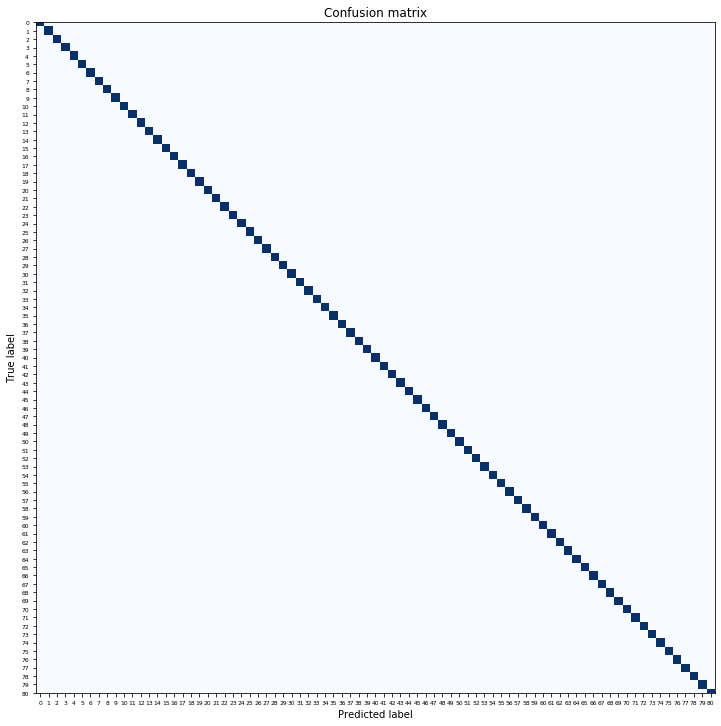

In [12]:
# make predictions for validation set
p_val = best_model.predict(X_val_embeddings_2d)

# get and plot confusion matrix
cm = confusion_matrix(y_val, p_val)

fig = plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, np.arange(81))
plt.savefig(output_path / f"confusion_{linear_classifier_model_name}.png")